# 🧮 Rock-Paper-Scissors Profitability Analyzer (Jupyter Notebook)

This notebook estimates the monthly **profitability** of a web-based Rock-Paper-Scissors tournament-style game. It models revenue from ads and costs from cloud infrastructure as the **daily user base scales**.

---

## 📦 Features

- 📈 **Deterministic model** with gradually increasing daily users
- 💰 Calculates ad-based earnings and cloud infrastructure costs
- 📉 Tracks bandwidth, CPU usage, and ROI per player count
- 📊 Includes clean, labeled plots to visualize profit dynamics

---

## ⚙️ Core Assumptions

| Category         | Detail                                |
|------------------|----------------------------------------|
| Players/day      | Ranges from 100 to 1000 (adjustable)   |
| Sessions/player  | 3 sessions/day                         |
| Rounds/session   | 3 rounds/session                       |
| Ads/round        | 4 ads shown                            |
| Ad revenue       | CPM ($2.5 per 1000 impressions)        |
| Bandwidth/ad     | 0.05MB                                 |
| CPU/session      | ~0.167 hours (~10 minutes)             |
| Cost/CPU hour    | $0.04                                  |
| Fixed costs      | CDN, logs, live DB, domain             |

---

## 📊 Visualizations

| Chart                     | Description                                      |
|--------------------------|--------------------------------------------------|
| **Profit vs Players**     | Shows monthly profit as user count increases    |
| **Earnings vs Costs**     | Revenue vs expense trend                        |
| **Bandwidth Usage**       | Tracks outgoing GBs by user load                |
| **ROI (%) per Players**   | Return on investment across user growth         |

---

## 📤 Usage

> 🔧 You can tweak:
> - `CPM`, `CPU_HOURS_PER_SESSION`, `ADS_PER_PAGE`
> - `player_range`: range of users to model (e.g., 100 to 1000)
> - Fixed infra costs or ad logic
> - Visual styles (color, size, titles)

---

## 🧠 Extensions

You could expand this notebook to include:
- Player retention models (e.g., DAU/MAU)
- Premium features / microtransactions
- Token-based economy with sinks
- Simulation mode with randomized trials
- Tiered compute (free vs paid sessions)

---

**Author**: Shadow  
**Created**: June 2025  
**License**: MIT



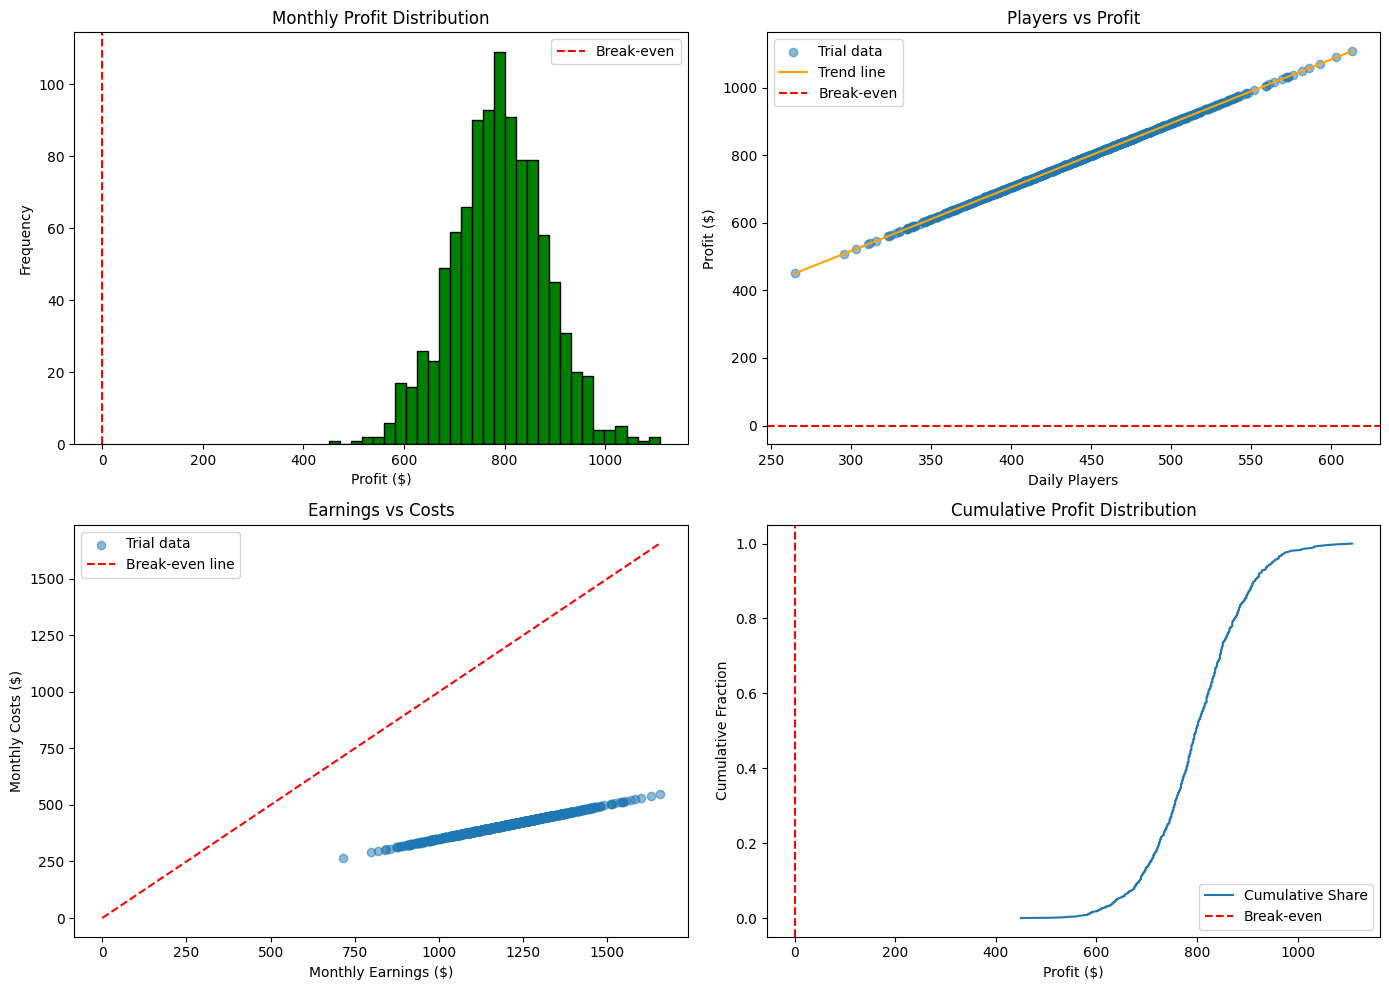

{'profitability_rate': 100.0,
 'avg_profit': 788.8517985181094,
 'max_profit': 1108.3778027031253,
 'min_profit': 450.11121976562487}

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Constants for game economics and hosting
CPM = 2.5  # Ad revenue per 1000 impressions
ADS_PER_PAGE = 4
ROUNDS_PER_SESSION = 3
SESSIONS_PER_PLAYER = 3
DAYS_IN_MONTH = 30
FREE_BANDWIDTH_GB = 1  # GCP free tier bandwidth
BANDWIDTH_PER_AD_MB = 0.05

# Hosting and Infra Costs (monthly estimates, updated June 2025)
COST_PER_GB = 0.025           # Updated: Standard storage in Europe, per GB per month
CPU_HOURS_PER_SESSION = 0.167 # Unchanged (usage pattern)
COST_PER_CPU_HOUR = 0.0537    # Updated: Cloud SQL vCPU hour (on-demand)
CDN_COST = 0.01        # Updated: Cloud CDN egress, per GiB
CDN_REQUEST_COST = 0.0075     # Updated: Cloud CDN, per 10,000 requests
LOGGING_INGEST_COST = 0.50    # Updated: Logging ingest, per GB (first 50 GB free)
LOGGING_STORAGE_COST = 0.01   # Updated: Logging storage, per GB per month (beyond 30 days)
LOGGING_COST = LOGGING_INGEST_COST + LOGGING_STORAGE_COST  # Monthly logging cost
DOMAIN_COST_MONTHLY = 12.00   # Updated: Typical .com/.org/.net/.dev domain via Google Domains
LIVE_DB_COST = 38.66  # Updated: Cloud SQL, 1 vCPU, 24/7 usage (excluding storage)


def simulate_month_realistic(base_players, variation=50, trials=1000):
    results = {'players': [], 'earnings': [], 'bandwidth': [], 'infra': [], 'costs': [], 'profit': []}

    for _ in range(trials):
        daily_players = max(10, int(random.gauss(base_players, variation)))
        daily_sessions = daily_players * SESSIONS_PER_PLAYER

        daily_impressions = daily_sessions * ROUNDS_PER_SESSION * ADS_PER_PAGE
        monthly_earnings = (daily_impressions / 1000) * CPM * DAYS_IN_MONTH

        total_bandwidth_gb = (daily_impressions * BANDWIDTH_PER_AD_MB / 1024) * DAYS_IN_MONTH
        bandwidth_cost = max(0, (total_bandwidth_gb - FREE_BANDWIDTH_GB) * COST_PER_GB)

        cpu_hours_monthly = daily_sessions * CPU_HOURS_PER_SESSION * DAYS_IN_MONTH
        compute_cost = cpu_hours_monthly * COST_PER_CPU_HOUR

        fixed_costs = CDN_COST + LOGGING_COST  + LIVE_DB_COST + DOMAIN_COST_MONTHLY
        total_cost = bandwidth_cost + compute_cost + fixed_costs

        profit = monthly_earnings - total_cost

        results['players'].append(daily_players)
        results['earnings'].append(monthly_earnings)
        results['bandwidth'].append(total_bandwidth_gb)
        results['infra'].append(compute_cost)
        results['costs'].append(total_cost)
        results['profit'].append(profit)

    return results

def analyze_profitability(results):
    profit = np.array(results['profit'])
    positive = profit[profit > 0]
    prob = len(positive) / len(profit) * 100
    avg_profit = np.mean(profit)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.hist(profit, bins=30, color='green', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', label='Break-even')
    plt.title("Monthly Profit Distribution")
    plt.xlabel("Profit ($)")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.scatter(results['players'], results['profit'], alpha=0.5, label='Trial data')
    z = np.polyfit(results['players'], results['profit'], 1)
    p = np.poly1d(z)
    plt.plot(sorted(results['players']), p(sorted(results['players'])), color='orange', label='Trend line')
    plt.axhline(0, color='red', linestyle='--', label='Break-even')
    plt.title("Players vs Profit")
    plt.xlabel("Daily Players")
    plt.ylabel("Profit ($)")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.scatter(results['earnings'], results['costs'], alpha=0.5, label='Trial data')
    plt.plot([0, max(results['earnings'])], [0, max(results['earnings'])], 'r--', label='Break-even line')
    plt.title("Earnings vs Costs")
    plt.xlabel("Monthly Earnings ($)")
    plt.ylabel("Monthly Costs ($)")
    plt.legend()

    plt.subplot(2, 2, 4)
    sorted_profit = np.sort(profit)
    cumulative = np.cumsum(sorted_profit) / np.sum(sorted_profit)
    plt.plot(sorted_profit, cumulative, label='Cumulative Share')
    plt.axvline(0, color='red', linestyle='--', label='Break-even')
    plt.title("Cumulative Profit Distribution")
    plt.xlabel("Profit ($)")
    plt.ylabel("Cumulative Fraction")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'profitability_rate': prob,
        'avg_profit': avg_profit,
        'max_profit': np.max(profit),
        'min_profit': np.min(profit)
    }

results = simulate_month_realistic(base_players=445, variation=50)
analysis = analyze_profitability(results)
analysis


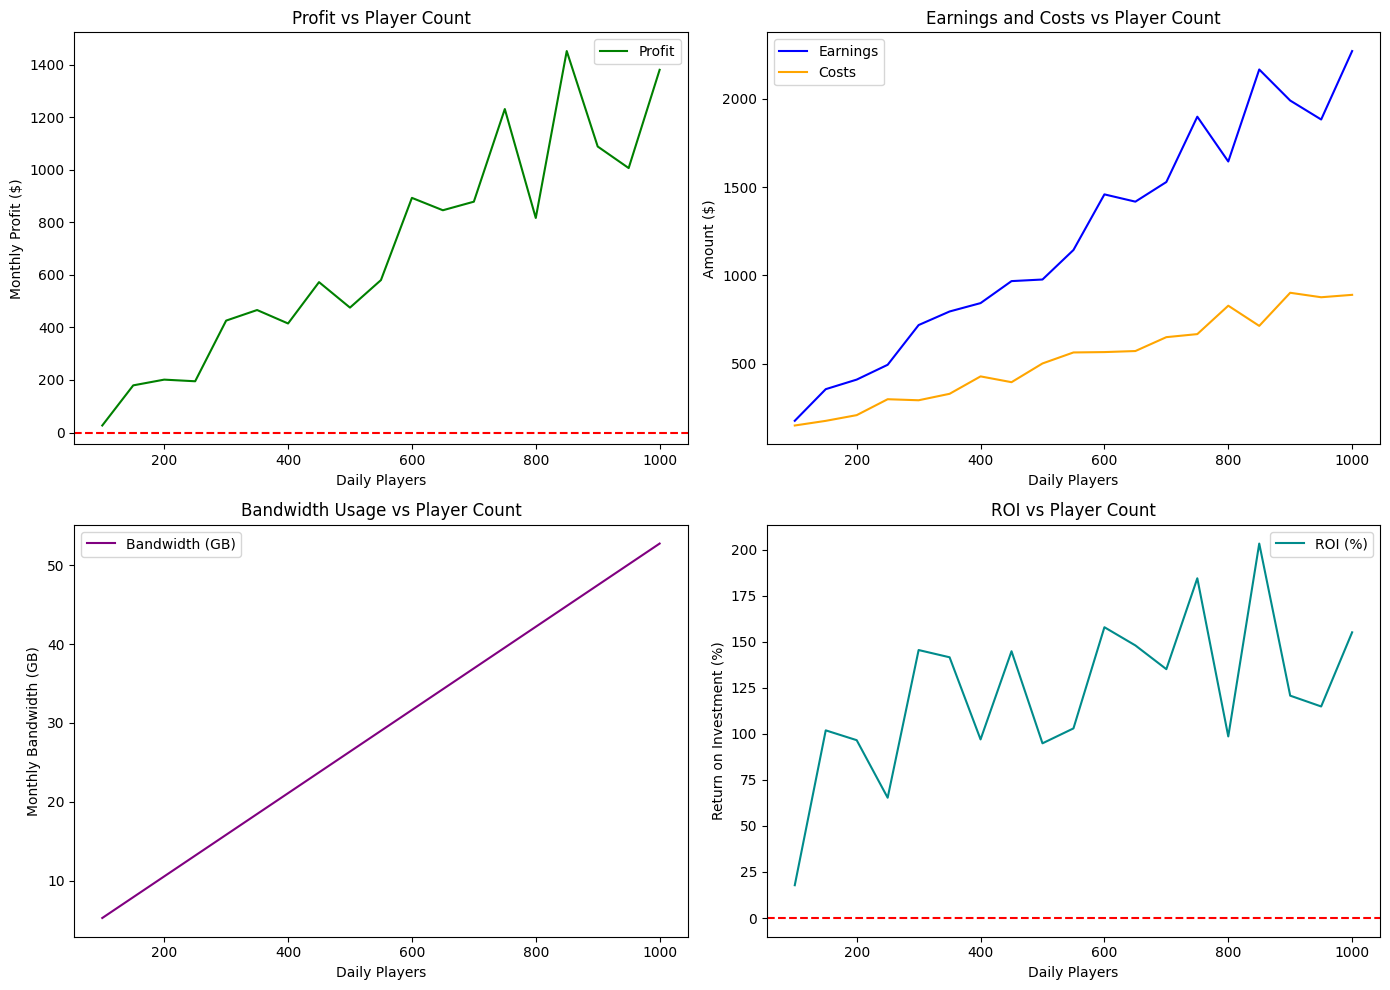

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
ADS_PER_PAGE = 4
ROUNDS_PER_SESSION = 3
SESSIONS_PER_PLAYER = 3
DAYS_IN_MONTH = 30
FREE_BANDWIDTH_GB = 1
BANDWIDTH_PER_AD_MB = 0.05

# Fixed monthly costs (updated June 2025)
CDN_COST = 5.0          # Estimated minimum for small traffic (usage-based)
LOGGING_COST = 5.0       # Estimated minimum for small projects (usage-based)
DOMAIN_COST_MONTHLY = 12.0  # .com/.org via Google Domains
LIVE_DB_COST = 38.66     # Cloud SQL: 1 vCPU, 24/7 (excludes storage)
FIXED_COSTS = CDN_COST + LOGGING_COST + DOMAIN_COST_MONTHLY + LIVE_DB_COST

# Variable cost constants (updated June 2025)
COST_PER_GB = 0.025       # Standard storage (Europe)
COST_PER_CPU_HOUR = 0.0537  # Cloud SQL vCPU hour


# Simulation across increasing user base
player_range = np.arange(100, 1001, 50)

# Prepare arrays to store results
profits, earnings, costs, bandwidths = [], [], [], []

for players in player_range:
    # Randomize key variables
    CPM = np.random.normal(2.0, 0.2)               # Ad revenue per 1K impressions
    CPU_HOURS_PER_SESSION = np.random.uniform(0.15, 0.2)  # CPU hours per session

    daily_sessions = players * SESSIONS_PER_PLAYER
    monthly_sessions = daily_sessions * DAYS_IN_MONTH

    ad_impressions = daily_sessions * ROUNDS_PER_SESSION * ADS_PER_PAGE * DAYS_IN_MONTH
    revenue = (ad_impressions / 1000) * CPM

    # Bandwidth usage (in GB)
    bandwidth_gb = (ad_impressions * BANDWIDTH_PER_AD_MB / 1024)
    bandwidth_cost = max(0, (bandwidth_gb - FREE_BANDWIDTH_GB) * COST_PER_GB)

    # Compute cost
    compute_cost = monthly_sessions * CPU_HOURS_PER_SESSION * COST_PER_CPU_HOUR

    total_cost = bandwidth_cost + compute_cost + FIXED_COSTS
    profit = revenue - total_cost

    # Store results
    profits.append(profit)
    earnings.append(revenue)
    costs.append(total_cost)
    bandwidths.append(bandwidth_gb)

# === Plotting ===
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(player_range, profits, label="Profit", color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Profit vs Player Count")
plt.xlabel("Daily Players")
plt.ylabel("Monthly Profit ($)")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(player_range, earnings, label="Earnings", color='blue')
plt.plot(player_range, costs, label="Costs", color='orange')
plt.title("Earnings and Costs vs Player Count")
plt.xlabel("Daily Players")
plt.ylabel("Amount ($)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(player_range, bandwidths, label="Bandwidth (GB)", color='purple')
plt.title("Bandwidth Usage vs Player Count")
plt.xlabel("Daily Players")
plt.ylabel("Monthly Bandwidth (GB)")
plt.legend()

plt.subplot(2, 2, 4)
roi = [(e - c) / c * 100 if c > 0 else 0 for e, c in zip(earnings, costs)]
plt.plot(player_range, roi, label="ROI (%)", color='darkcyan')
plt.axhline(0, color='red', linestyle='--')
plt.title("ROI vs Player Count")
plt.xlabel("Daily Players")
plt.ylabel("Return on Investment (%)")
plt.legend()

plt.tight_layout()
plt.show()
